## Read Me Section

Created by - Samir Paul

ERA1 - Assignment for "Session 10 "

Dataset = CIFAR10
Used Pytorch Framework

Requirement is to use batch size of 512, use One Cycle LR policy, with a custom ResNet kind of Model (specification given below)

Target is to achieve 90% test accuracy within 24 epochs

Model Specification given below:

PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]

Layer1 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]

R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]

Add(X, R1)

Layer 2 -

Conv 3x3 [256k]

MaxPooling2D

BN

ReLU


Layer 3 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]


R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]


Add(X, R2)

MaxPooling with Kernel Size 4


FC Layer


SoftMax

Uses One Cycle Policy such that:

Total Epochs = 24

Max at Epoch = 5

LRMIN = FIND

LRMAX = FIND

NO Annihilation


## Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

!pip install torch_lr_finder
from torch_lr_finder import LRFinder
import torch.optim as optim

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


**Importing my Custom Library - Modular Code**

In [3]:

import mymodels as mymodel
import mytrain
import mytest



In [4]:
import torchvision
import torch
import torchvision.transforms as transforms
# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

class Cifar10SearchDataset(torchvision.datasets.CIFAR10):

    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label



In [5]:


train_transforms = A.Compose(
    [
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), always_apply=False, p=0.5),
        A.RandomCrop(32, 32, p=4),
        #A.HorizontalFlip(p=0.5),
        A.Resize(32, 32),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
        ToTensorV2(),
    ]
)

In [6]:

train_data = Cifar10SearchDataset(root='./data', train=True,download=True, transform=train_transforms)
test_data = Cifar10SearchDataset(root='./data', train=False,download=True, transform=test_transforms)



100%|██████████| 170498071/170498071 [00:12<00:00, 13145346.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [8]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


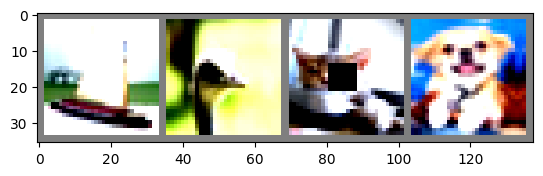

ship  bird  cat   dog  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [10]:
print( '+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++'  )
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = mymodel.Model_S10().to(device)
summary(model, input_size=(3, 32, 32))

+++++++++++++++++++++++ Parameters for Batch Normalization Model +++++++++++++++++++++++++++++++++++
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             2

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.28E-04


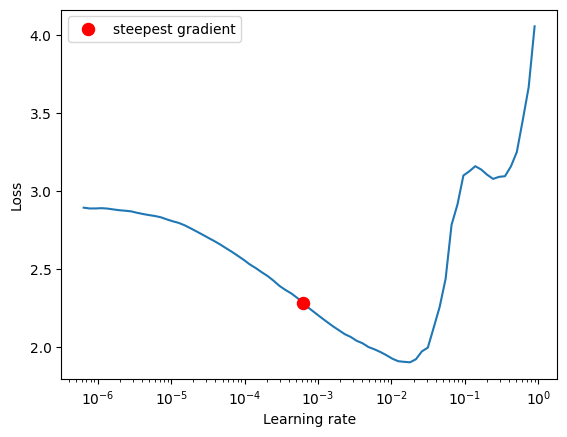

In [11]:


!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

model = mymodel.Model_S10().to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4) # R
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
#lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")  # R
lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [12]:

EPOCHS = 24
model =  mymodel.Model_S10().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1.67E-01, weight_decay=1e-2)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-2)

scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=6.28E-04,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    criterion =  nn.CrossEntropyLoss()
    mytrain.train11(model, device, train_loader, optimizer, epoch, criterion, scheduler)

    # scheduler.step()
    mytest.test11(model, device, test_loader)



EPOCH: 0


Loss=1.3350017070770264 Batch_id=97 Accuracy=35.89: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set:  Accuracy: 5405/10000 (54.05%)

EPOCH: 1


Loss=0.8995171785354614 Batch_id=97 Accuracy=59.28: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set:  Accuracy: 6661/10000 (66.61%)

EPOCH: 2


Loss=0.7998847961425781 Batch_id=97 Accuracy=69.44: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set:  Accuracy: 7262/10000 (72.62%)

EPOCH: 3


Loss=0.6810728311538696 Batch_id=97 Accuracy=74.66: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set:  Accuracy: 7334/10000 (73.34%)

EPOCH: 4


Loss=0.6680170893669128 Batch_id=97 Accuracy=78.04: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set:  Accuracy: 7618/10000 (76.18%)

EPOCH: 5


Loss=0.6705420613288879 Batch_id=97 Accuracy=80.24: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]



Test set:  Accuracy: 7888/10000 (78.88%)

EPOCH: 6


Loss=0.4871533215045929 Batch_id=97 Accuracy=82.45: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set:  Accuracy: 7833/10000 (78.33%)

EPOCH: 7


Loss=0.47063153982162476 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set:  Accuracy: 8326/10000 (83.26%)

EPOCH: 8


Loss=0.4337579309940338 Batch_id=97 Accuracy=85.13: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set:  Accuracy: 8355/10000 (83.55%)

EPOCH: 9


Loss=0.3830319344997406 Batch_id=97 Accuracy=85.95: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set:  Accuracy: 8323/10000 (83.23%)

EPOCH: 10


Loss=0.32337504625320435 Batch_id=97 Accuracy=86.66: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set:  Accuracy: 8465/10000 (84.65%)

EPOCH: 11


Loss=0.26409897208213806 Batch_id=97 Accuracy=87.84: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set:  Accuracy: 8223/10000 (82.23%)

EPOCH: 12


Loss=0.30221325159072876 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set:  Accuracy: 8322/10000 (83.22%)

EPOCH: 13


Loss=0.35422754287719727 Batch_id=97 Accuracy=89.16: 100%|██████████| 98/98 [00:20<00:00,  4.89it/s]



Test set:  Accuracy: 8361/10000 (83.61%)

EPOCH: 14


Loss=0.311664342880249 Batch_id=97 Accuracy=89.74: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set:  Accuracy: 8686/10000 (86.86%)

EPOCH: 15


Loss=0.22324487566947937 Batch_id=97 Accuracy=90.54: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set:  Accuracy: 8561/10000 (85.61%)

EPOCH: 16


Loss=0.3268063962459564 Batch_id=97 Accuracy=91.10: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set:  Accuracy: 8814/10000 (88.14%)

EPOCH: 17


Loss=0.19105057418346405 Batch_id=97 Accuracy=91.94: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set:  Accuracy: 8862/10000 (88.62%)

EPOCH: 18


Loss=0.21111547946929932 Batch_id=97 Accuracy=92.72: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set:  Accuracy: 8745/10000 (87.45%)

EPOCH: 19


Loss=0.180204838514328 Batch_id=97 Accuracy=93.66: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set:  Accuracy: 8939/10000 (89.39%)

EPOCH: 20


Loss=0.1789194643497467 Batch_id=97 Accuracy=94.61: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set:  Accuracy: 9011/10000 (90.11%)

EPOCH: 21


Loss=0.16162535548210144 Batch_id=97 Accuracy=95.76: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set:  Accuracy: 9143/10000 (91.43%)

EPOCH: 22


Loss=0.0868162289261818 Batch_id=97 Accuracy=96.60: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set:  Accuracy: 9262/10000 (92.62%)

EPOCH: 23


Loss=0.0797014981508255 Batch_id=97 Accuracy=97.55: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set:  Accuracy: 9300/10000 (93.00%)



In [13]:
from mytrain import  lrs

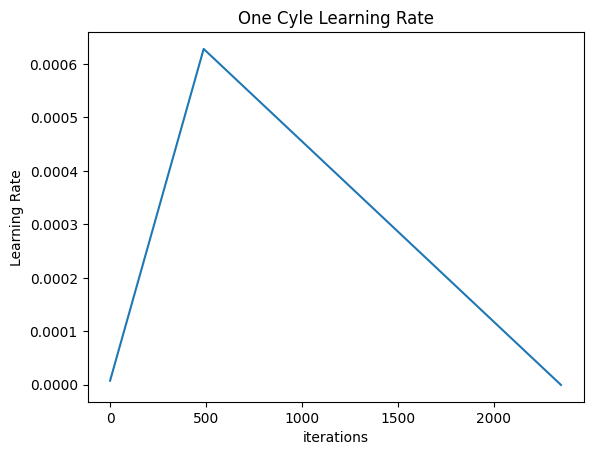

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(lrs)
plt.xlabel('iterations')
plt.ylabel('Learning Rate')

# displaying the title
plt.title("One Cyle Learning Rate")
plt.show()

In [15]:
from mytrain import train_losses, train_acc

Text(0.5, 1.0, 'Training Accuracy')

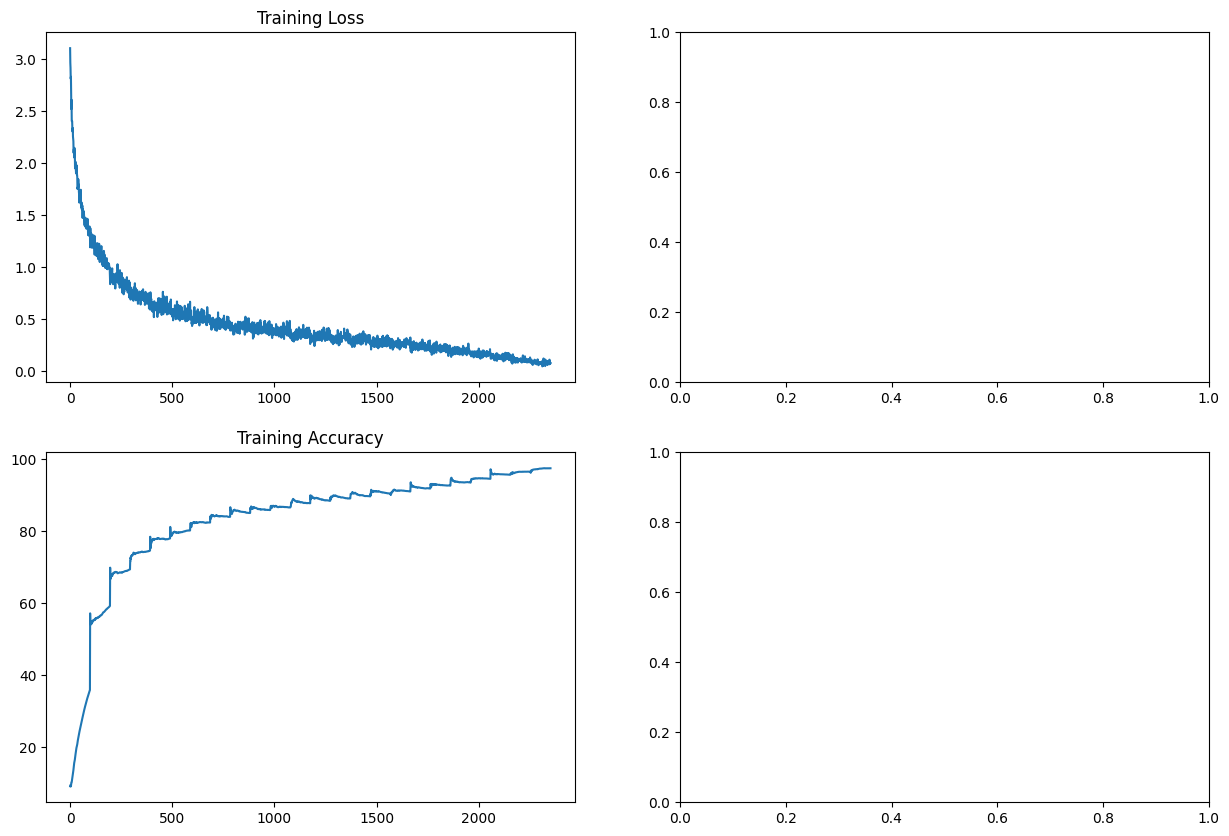

In [16]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
#axs[0, 1].plot(test_losses)
#axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
#axs[1, 1].set_title("Test Accuracy")

In [19]:
import  utils

Files already downloaded and verified
(1600000, 32, 3)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Classes in order Actual and Predicted


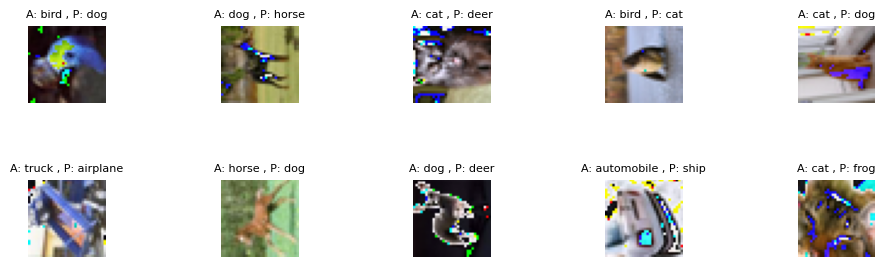

In [21]:
true_wrongs, incorrect_example, pred_incorrect = utils.get_incorrect_preds(model, test_loader)
utils.plot_incorrect_preds(true_wrongs, incorrect_example, pred_incorrect)